In [4]:
from generation import process_with_new_beam_search
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import os
import logging

import inspect
import torch

from utils import levenshtein, split_in_sentence

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from transformers.generation import utils
#from transformers.generation.beam_search import BeamSearchScorer
from beam_search import BeamSearchScorer
from beam_search import _new_beam_search
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union
from transformers.utils import ModelOutput
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation.stopping_criteria import (
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteria,
    StoppingCriteriaList,
    validate_stopping_criteria,
)
from transformers.generation.logits_process import (
    EncoderNoRepeatNGramLogitsProcessor,
    EncoderRepetitionPenaltyLogitsProcessor,
    EpsilonLogitsWarper,
    EtaLogitsWarper,
    ExponentialDecayLengthPenalty,
    ForcedBOSTokenLogitsProcessor,
    ForcedEOSTokenLogitsProcessor,
    ForceTokensLogitsProcessor,
    HammingDiversityLogitsProcessor,
    InfNanRemoveLogitsProcessor,
    LogitNormalization,
    LogitsProcessorList,
    MinLengthLogitsProcessor,
    MinNewTokensLengthLogitsProcessor,
    NoBadWordsLogitsProcessor,
    NoRepeatNGramLogitsProcessor,
    PrefixConstrainedLogitsProcessor,
    RepetitionPenaltyLogitsProcessor,
    SequenceBiasLogitsProcessor,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TypicalLogitsWarper,
    ClassifierFreeGuidanceLogitsProcessor,
)

In [5]:
utils.beam_search = _new_beam_search
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang="ita_Latn", tgt_lang="ita_Latn")
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
num_beam_groups = 1

alphas = [0.6,0.7,0.8,0.9] # when aplha is 1 - no levenshtein distance

C:\Users\Anton\anaconda3\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
from utils import gt_bio
import spacy

nlp = spacy.load("it_core_news_lg")

In [3]:
df = pd.read_csv('dev_set2.csv')
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,OCR_Text,Ground_True,Checked,v1_Errors 0.3,v1_Errors 0.4,v1_Errors 0.5,v1_Errors 0.6,...,r_v1_Errors a0.3 d2,r_v1_Errors % a0.3 d2,r_v1_Errors a0.3 d3,r_v1_Errors % a0.3 d3,r_v1_Errors a0.3 d4,r_v1_Errors % a0.3 d4,r_v1_Errors a0.3 d5,r_v1_Errors % a0.3 d5,r_v1_Errors a0.3 d6,r_v1_Errors % a0.3 d6
0,0,0,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,True,1,1,1,1,...,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000
1,1,1,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...,True,1,1,1,1,...,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000
2,2,2,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C...",True,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,3,3,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...",True,0,0,0,0,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,4,4,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",True,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,5,5,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,True,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,6,6,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...,True,196,196,196,196,...,854.0,3.795556,854.0,3.795556,854.0,3.795556,854.0,3.795556,854.0,3.795556
7,7,7,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c...",True,2,2,2,1,...,2.0,1.000000,2.0,1.000000,2.0,1.000000,2.0,1.000000,2.0,1.000000
8,8,8,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r...",True,16,16,16,16,...,7.0,0.388889,7.0,0.388889,7.0,0.388889,7.0,0.388889,7.0,0.388889
9,9,9,27,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,True,54,54,51,50,...,54.0,0.830769,54.0,0.830769,55.0,0.846154,55.0,0.846154,55.0,0.846154


In [4]:
gt = df[['Unnamed: 0','OCR_Text', 'Ground_True']].copy()
gt

,Unnamed: 0,OCR_Text,Ground_True
0,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...
1,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...
2,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C..."
3,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ..."
4,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s..."
5,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...
6,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...
7,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c..."
8,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r..."
9,27,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...


Add colums for text end error (distacne)

Not all entries are checked for errors. Enties that have GT text are marked as Checked (Checked = True)

In [5]:
for alpha in alphas:
    gt['Text {}'.format(alpha)] = None
    gt['Error {}'.format(alpha)] = None
gt

,Unnamed: 0,OCR_Text,Ground_True,Text 0.6,Error 0.6,Text 0.7,Error 0.7,Text 0.8,Error 0.8,Text 0.9,Error 0.9
0,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,None,None,None,None,None,None,None,None
1,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...,None,None,None,None,None,None,None,None
2,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C...",None,None,None,None,None,None,None,None
3,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...",None,None,None,None,None,None,None,None
4,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",None,None,None,None,None,None,None,None
5,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,None,None,None,None,None,None,None,None
6,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...,None,None,None,None,None,None,None,None
7,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c...",None,None,None,None,None,None,None,None
8,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r...",None,None,None,None,None,None,None,None
9,27,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,None,None,None,None,None,None,None,None


I just separated data in 2 equal chunks (in practice is useless), but I made calculations from 2/3 of total corrected

In [6]:
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

computation of text and errors

separate text in sentences (without it i have memory problem) and use process_with_new_beam_search function to call generate

In [8]:
def wrap(s, w):
    return [s[i:i + w] for i in range(0, len(s), w)]

In [9]:
# TODO add save/update to file after each row
# TODO separate some rows into 2 portions, run other on another PC
output_path = 'dev_set3.csv'
logging.basicConfig(filename='errors.log', filemode='a', encoding='utf-8', level=logging.DEBUG)
for index, row in tqdm(gt.iterrows(), total=gt.shape[0], desc="df"):
    ocr_text = row['OCR_Text']
    splitted_text = split_in_sentence(ocr_text)
    beam_width = 5
    
    gt_text = row['Ground_True']
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    for alpha in tqdm(alphas, leave=False, desc="alpha"):
        try:
            translated_text = []
            for text in tqdm(splitted_text, leave=False, desc="splitted_text"):
                if len(text) > 1024:
                    sub_text = wrap(text, 1024)
                    for st in sub_text:
                        txt = process_with_new_beam_search(model, tokenizer, st, beam_width, device, alpha = alpha) #beam_search
                        translated_text.append(txt)
                else:
                    txt = process_with_new_beam_search(model, tokenizer, text, beam_width, device, alpha = alpha) #beam_search
                    translated_text.append(txt)
            text = ' '.join(translated_text)
            gt.loc[index, 'Text {}'.format(alpha)] = text
            gt.loc[index, 'Error {}'.format(alpha)] = levenshtein(text,row['Ground_True'])
            row['Text {}'.format(alpha)] = text
            
            print(text)
            text_words = []
            doc = nlp(text)
            for token in doc:
                text_words.append(token.text)
            row['Error {}'.format(alpha)] = gt_bio(correct_text_words, text_words).count(False)
        except Exception as e:
            print('Error')
            logging.info('===========================')
            logging.info('index')
            logging.info(index)
            logging.info('text:')
            logging.info(text)
            logging.error(e, exc_info=True)
            continue
    clear_output(wait=True)
    row.to_frame().T.to_csv(output_path, index=False, mode='a', header=not os.path.exists(output_path))

df: 100%|█████████████████████████████████| 16/16 [28:50:27<00:00, 6489.21s/it]


In [10]:
gt

,Unnamed: 0,OCR_Text,Ground_True,Text 0.6,Error 0.6,Text 0.7,Error 0.7,Text 0.8,Error 0.8,Text 0.9,Error 0.9
0,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. E' l. L'onorevole Anna Teresa Form...,21,PRESIDENTE. - E' l. L'onorevole Anna Teresa Fo...,23,PRESIDENTE. L'onorevole Anna Teresa Formisano ...,12,"- Il mio nome è ""L'Uccitæu- L'onorevole Anna T...",43
1,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. - L. L'onorevole Bianco parlerà del co...,16,LACONI. - La. L'onorevole Bianco parlerà del c...,16,LACONI. L'onorevole Bianco parlerà del congegn...,9,LACONI. L'onorevole Bianco parlerà del congegn...,10
2,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35..... ...",10,"CARLO LEONI La seduta comincia alle 9,35..... ...",10,"CARLO LEONI La seduta comincia alle 9,35.... L...",9,"CARLO LEONI La seduta comincia alle 9.30: ""C"" ...",17
3,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...",5,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",8,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",8,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",10
4,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...","FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",8,"FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",8,"FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",6,"FRANCESCO GIULIO BAGHINO. Per i denti, vorrei ...",12
5,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",22,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",28,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",29,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",27
6,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...,None,None,None,None,None,None,None,None
7,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c...","GOMBI. - E? Tra l'altro, i consigli provincial...",15,"GOMBI. - E? Tra l'altro, i consigli provincial...",14,"GOMBIA: Sì Tra l'altro, i consigli provincial ...",14,"GOMBIA: Tra l'altro, i consigli provincial i e...",14
8,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r...","EDDA FAGNILL. Signor Presidente, colleghi, noi...",246,"EDDA FAGNILL. Signor Presidente, colleghi, noi...",253,"EDDA FAGNILLIA. Signor Presidente, colleghi, n...",134,"EDDA FAGNILLIA. Signor Presidente, colleghi, n...",140
9,27,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,None,None,None,None,None,None,None,None


In [3]:
import pandas as pd
done = pd.read_csv("dev_set3.csv")

In [7]:
done['Orriginal Error'] = None
for index, row in done.iterrows():
    gt_text = row['Ground_True']
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    ocr_text = row['OCR_Text']
    text_words = []
    doc = nlp(ocr_text)
    for token in doc:
        text_words.append(token.text)
        
    done.loc[index, 'Orriginal Error'] = gt_bio(correct_text_words, text_words).count(False)
done

,Unnamed: 0,OCR_Text,Ground_True,Text 0.6,Error 0.6,Text 0.7,Error 0.7,Text 0.8,Error 0.8,Text 0.9,Error 0.9,Orriginal Error
0,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
5,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
6,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233
7,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
9,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [11]:
done = done[26:]

In [12]:
done

,Unnamed: 0,OCR_Text,Ground_True,Text 0.6,Error 0.6,Text 0.7,Error 0.7,Text 0.8,Error 0.8,Text 0.9,Error 0.9,Orriginal Error
26,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. E' l. L'onorevole Anna Teresa Form...,13.0,PRESIDENTE. - E' l. L'onorevole Anna Teresa Fo...,37.0,PRESIDENTE. L'onorevole Anna Teresa Formisano ...,30.0,"- Il mio nome è ""L'Uccitæu- L'onorevole Anna T...",40.0,1
27,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. - L. L'onorevole Bianco parlerà del co...,8.0,LACONI. - La. L'onorevole Bianco parlerà del c...,16.0,LACONI. L'onorevole Bianco parlerà del congegn...,5.0,LACONI. L'onorevole Bianco parlerà del congegn...,7.0,1
28,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35..... ...",7.0,"CARLO LEONI La seduta comincia alle 9,35..... ...",6.0,"CARLO LEONI La seduta comincia alle 9,35.... L...",6.0,"CARLO LEONI La seduta comincia alle 9.30: ""C"" ...",19.0,0
29,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,0
30,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...","FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",8.0,"FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",8.0,"FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",6.0,"FRANCESCO GIULIO BAGHINO. Per i denti, vorrei ...",7.0,2
31,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",8.0,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",10.0,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",10.0,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",13.0,3
32,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233
33,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c...","GOMBI. - E? Tra l'altro, i consigli provincial...",15.0,"GOMBI. - E? Tra l'altro, i consigli provincial...",16.0,"GOMBIA: Sì Tra l'altro, i consigli provincial ...",11.0,"GOMBIA: Tra l'altro, i consigli provincial i e...",10.0,2
34,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r...","EDDA FAGNILL. Signor Presidente, colleghi, noi...",203.0,"EDDA FAGNILL. Signor Presidente, colleghi, noi...",226.0,"EDDA FAGNILLIA. Signor Presidente, colleghi, n...",61.0,"EDDA FAGNILLIA. Signor Presidente, colleghi, n...",69.0,26
35,27,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65


In [19]:
alpha = 0.6
row = done.iloc[0]
ocr_text = row['Text {}'.format(alpha)]
ocr_text

'PRESIDENTE. E\' l. L\'onorevole Anna Teresa Formisano ha facoltà di illustrare l\'interpellanza Volontè n. 2-00578, concernente iniziative del Governo nell\'ambito dell\\\\\'anno europeo della lotta alla povertà e allesclusione sociale (vedi lallegato A  Interpellanze urgenti), di cui è cofirmataria.. " (s)'

In [20]:
import math
alphas = [0.6,0.7,0.8,0.9] # when aplha is 1 - no levenshtein distance
for alpha in alphas:
    done['Error {} %'.format(alpha)] = None
for index, row in done.iterrows():
    
    gt_text = row['Ground_True']
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
        
    for alpha in alphas:
        if pd.isnull(row['Text {}'.format(alpha)]):
            continue
        ocr_text = row['Text {}'.format(alpha)]
        text_words = []
        doc = nlp(ocr_text)
        for token in doc:
            text_words.append(token.text)
            
        error = gt_bio(correct_text_words, text_words).count(False)
        if row["Orriginal Error"] != 0:
            done.loc[index, 'Error {} %'.format(alpha)] = error/row["Orriginal Error"]
        else:
            if error > 0:
                done.loc[index, 'Error {} %'.format(alpha)] = 1
            else:
                done.loc[index, 'Error {} %'.format(alpha)] = 0
done

C:\Users\Anton\AppData\Local\Temp\ipykernel_38152\627171801.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  done['Error {} %'.format(alpha)] = None


,Unnamed: 0,OCR_Text,Ground_True,Text 0.6,Error 0.6,Text 0.7,Error 0.7,Text 0.8,Error 0.8,Text 0.9,Error 0.9,Orriginal Error,Error 0.6 %,Error 0.7 %,Error 0.8 %,Error 0.9 %
26,33,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. L’onorevole Anna Teresa Formisano ...,PRESIDENTE. E' l. L'onorevole Anna Teresa Form...,13.0,PRESIDENTE. - E' l. L'onorevole Anna Teresa Fo...,37.0,PRESIDENTE. L'onorevole Anna Teresa Formisano ...,30.0,"- Il mio nome è ""L'Uccitæu- L'onorevole Anna T...",40.0,1,13.0,37.0,30.0,40.0
27,23,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. L’onorevole Bianco parlerà del congegn...,LACONI. - L. L'onorevole Bianco parlerà del co...,8.0,LACONI. - La. L'onorevole Bianco parlerà del c...,16.0,LACONI. L'onorevole Bianco parlerà del congegn...,5.0,LACONI. L'onorevole Bianco parlerà del congegn...,7.0,1,8.0,16.0,5.0,7.0
28,40,"CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35. La C...","CARLO LEONI La seduta comincia alle 9,35..... ...",7.0,"CARLO LEONI La seduta comincia alle 9,35..... ...",6.0,"CARLO LEONI La seduta comincia alle 9,35.... L...",6.0,"CARLO LEONI La seduta comincia alle 9.30: ""C"" ...",19.0,0,1,1,1,1
29,37,"COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...","COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,"COSIMO VENTUCCI, Sottosegretario di Stato per ...",5.0,0,1,1,1,1
30,2,"FRANCESCO GIULIO BAGHINO . Presi dente, vorrei...","FRANCESCO GIULIO BAGHINO. Presidente, vorrei s...","FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",8.0,"FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",8.0,"FRANCESCO GIULIO BAGHINO. Presi dente, vorrei ...",6.0,"FRANCESCO GIULIO BAGHINO. Per i denti, vorrei ...",7.0,2,4.0,4.0,3.0,3.5
31,3,"(Trasmissione dal Senato) \t 18567 ANDREOTTI, ...",(Trasmissione dal Senato) 18567 ANDRE...,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",8.0,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",10.0,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",10.0,"(Trasmissione dal Senato) 18567 ANDREOTTI, Min...",13.0,3,2.666667,3.333333,3.333333,4.333333
32,31,CALASSO. L’onorevole Vanoni affermò che avrebb...,CALASSO. L’onorevole Vanoni affermò che avrebb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233,None,None,None,None
33,26,"GOMBI . Tra l'altro, i consigli provincial i e...","GOMBI. Tra l'altro, i consigli provinciali e c...","GOMBI. - E? Tra l'altro, i consigli provincial...",15.0,"GOMBI. - E? Tra l'altro, i consigli provincial...",16.0,"GOMBIA: Sì Tra l'altro, i consigli provincial ...",11.0,"GOMBIA: Tra l'altro, i consigli provincial i e...",10.0,2,7.5,8.0,5.5,5.0
34,46,"EDDA FAGNI . Signor Presidente, colleghi, noi ...","EDDA FAGNI. Signor Presidente, colleghi, noi r...","EDDA FAGNILL. Signor Presidente, colleghi, noi...",203.0,"EDDA FAGNILL. Signor Presidente, colleghi, noi...",226.0,"EDDA FAGNILLIA. Signor Presidente, colleghi, n...",61.0,"EDDA FAGNILLIA. Signor Presidente, colleghi, n...",69.0,26,7.807692,8.692308,2.346154,2.653846
35,27,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,X LEGISLATURA - DISCUSSIONI - SEDUTA DEL 18 OT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,None,None,None,None


In [21]:
freq = done[['Error 0.6 %', 'Error 0.7 %', 'Error 0.8 %', 'Error 0.9 %']]
freq

,Error 0.6 %,Error 0.7 %,Error 0.8 %,Error 0.9 %
26,13.0,37.0,30.0,40.0
27,8.0,16.0,5.0,7.0
28,1,1,1,1
29,1,1,1,1
30,4.0,4.0,3.0,3.5
31,2.666667,3.333333,3.333333,4.333333
32,None,None,None,None
33,7.5,8.0,5.5,5.0
34,7.807692,8.692308,2.346154,2.653846
35,None,None,None,None


In [22]:
freq = freq.fillna(freq.mean())
freq

,Error 0.6 %,Error 0.7 %,Error 0.8 %,Error 0.9 %
26,13.000000,37.000000,30.000000,40.000000
27,8.000000,16.000000,5.000000,7.000000
28,1.000000,1.000000,1.000000,1.000000
29,1.000000,1.000000,1.000000,1.000000
30,4.000000,4.000000,3.000000,3.500000
31,2.666667,3.333333,3.333333,4.333333
32,7.937580,11.457811,5.367794,7.044144
33,7.500000,8.000000,5.500000,5.000000
34,7.807692,8.692308,2.346154,2.653846
35,7.937580,11.457811,5.367794,7.044144


<Axes: >

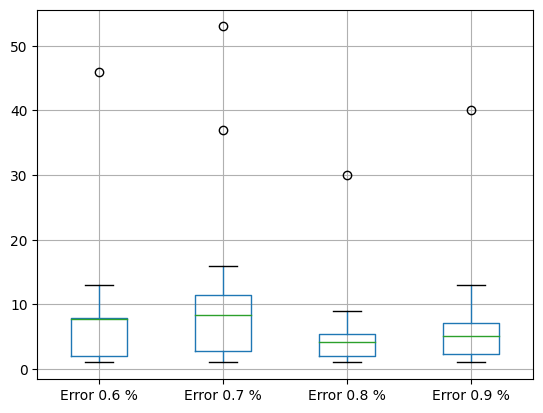

In [23]:
freq.boxplot()

In [24]:
freq.mean()

Error 0.6 %     7.937580
Error 0.7 %    11.457811
Error 0.8 %     5.367794
Error 0.9 %     7.044144
dtype: float64

test_set

In [7]:
data = pd.read_csv("test_set.csv")

In [8]:
data

,Unnamed: 0,OCR_Text,Ground_True,Checked,v1_Errors a0.3,v1_Errors % a0.3,v1_Errors a0.5,v1_Errors % a0.5,GT_Errors,v2_Errors a0.5 b0.1,v2_Errors % a0.5 b0.1
0,0,"MORINI, Segretmio, legge: (C Per gli intervent...","MORINI, Segretario, legge: « Per gli intervent...",True,13.0,0.928571,13.0,0.928571,14.0,12.0,0.857143
1,1,GIORGIO NEBBIA. Solo per ricordare che anche i...,GIORGIO NEBBIA. Solo per ricordare che anche i...,True,2.0,1.000000,2.0,1.000000,2.0,2.0,1.000000
2,4,due controllate dal gruppo FIAT tramite la Gil...,due controllate dal gruppo FIAT tramite la Gil...,True,5.0,0.714286,5.0,0.714286,7.0,5.0,0.714286
3,5,BATTISTI NI 21208 Sostituzione di un C...,BATTISTINI 21208 Sostituzione di un Co...,True,27.0,1.000000,27.0,1.000000,27.0,27.0,1.000000
4,6,PRESIDENTE . Sono stati presentati i seguenti ...,PRESIDENTE. Sono stati presentati i seguenti e...,True,17.0,0.361702,17.0,0.361702,47.0,23.0,0.489362
5,7,ADELE FACCIO. Noi chiediamo che le disposizion...,ADELE FACCIO. Noi chiediamo che le disposizion...,True,3.0,0.750000,3.0,0.750000,4.0,5.0,1.250000
6,8,"ERNESTO STAJANO, Presidente della IX Commissio...","ERNESTO STAJANO, Presidente della IX Commissio...",True,0.0,NaN,0.0,NaN,0.0,0.0,NaN
7,9,S. 1695. — Senatori MORA ed altri: «Modifiche ...,S. 1695. — Senatori MORA ed altri: «Modifiche ...,True,1.0,1.000000,1.0,1.000000,1.0,2.0,2.000000
8,10,"GALDO. Signor Presidente, onorevoli col leghi,...","GALDO. Signor Presidente, onorevoli colleghi, ...",True,69.0,0.543307,69.0,0.543307,127.0,76.0,0.598425
9,11,"ROBERTO OCCHIUTO. Presidente, il collega Vella...","ROBERTO OCCHIUTO. Presidente, il collega Vella...",True,0.0,NaN,0.0,NaN,0.0,0.0,NaN


In [9]:
test_set = data[['OCR_Text','Ground_True', 'GT_Errors']].copy()

In [10]:
test_set

,OCR_Text,Ground_True,GT_Errors
0,"MORINI, Segretmio, legge: (C Per gli intervent...","MORINI, Segretario, legge: « Per gli intervent...",14.0
1,GIORGIO NEBBIA. Solo per ricordare che anche i...,GIORGIO NEBBIA. Solo per ricordare che anche i...,2.0
2,due controllate dal gruppo FIAT tramite la Gil...,due controllate dal gruppo FIAT tramite la Gil...,7.0
3,BATTISTI NI 21208 Sostituzione di un C...,BATTISTINI 21208 Sostituzione di un Co...,27.0
4,PRESIDENTE . Sono stati presentati i seguenti ...,PRESIDENTE. Sono stati presentati i seguenti e...,47.0
5,ADELE FACCIO. Noi chiediamo che le disposizion...,ADELE FACCIO. Noi chiediamo che le disposizion...,4.0
6,"ERNESTO STAJANO, Presidente della IX Commissio...","ERNESTO STAJANO, Presidente della IX Commissio...",0.0
7,S. 1695. — Senatori MORA ed altri: «Modifiche ...,S. 1695. — Senatori MORA ed altri: «Modifiche ...,1.0
8,"GALDO. Signor Presidente, onorevoli col leghi,...","GALDO. Signor Presidente, onorevoli colleghi, ...",127.0
9,"ROBERTO OCCHIUTO. Presidente, il collega Vella...","ROBERTO OCCHIUTO. Presidente, il collega Vella...",0.0


In [8]:
def wrap(s, w):
    return [s[i:i + w] for i in range(0, len(s), w)]

In [ ]:
alphas = [0.8]

output_path = 'test_set2.csv'
logging.basicConfig(filename='errors.log', filemode='a', encoding='utf-8', level=logging.DEBUG)
for index, row in tqdm(test_set.iterrows(), total=test_set.shape[0], desc="df"):
    ocr_text = row['OCR_Text']
    splitted_text = split_in_sentence(ocr_text)
    beam_width = 5
    
    gt_text = row['Ground_True']
    correct_text_words = []
    doc = nlp(gt_text)
    for token in doc:
        correct_text_words.append(token.text)
    
    for alpha in tqdm(alphas, leave=False, desc="alpha"):
        try:
            translated_text = []
            for text in tqdm(splitted_text, leave=False, desc="splitted_text"):
                if len(text) > 1024:
                    sub_text = wrap(text, 1024)
                    for st in sub_text:
                        txt = process_with_new_beam_search(model, tokenizer, st, beam_width, device, alpha = alpha) #beam_search
                        translated_text.append(txt)
                else:
                    txt = process_with_new_beam_search(model, tokenizer, text, beam_width, device, alpha = alpha) #beam_search
                    translated_text.append(txt)
            text = ' '.join(translated_text)
            test_set.loc[index, 'Text {}'.format(alpha)] = text
            row['Text {}'.format(alpha)] = text
            
            print(text)
            text_words = []
            doc = nlp(text)
            for token in doc:
                text_words.append(token.text)
            test_set.loc[index, 'Error {}'.format(alpha)] = gt_bio(correct_text_words, text_words).count(False)
            row['Error {}'.format(alpha)] = gt_bio(correct_text_words, text_words).count(False)
        except Exception as e:
            print('Error')
            logging.info('===========================')
            logging.info('index')
            logging.info(index)
            logging.info('text:')
            logging.info(text)
            logging.error(e, exc_info=True)
            continue
    clear_output(wait=True)
    row.to_frame().T.to_csv(output_path, index=False, mode='a', header=not os.path.exists(output_path))

alpha:   0%|                                             | 0/1 [00:00<?, ?it/s]

splitted_text:   0%|                                     | 0/6 [00:00<?, ?it/s]the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
